## KL Divergence with bimodal posterior

Implementation of forward and reverse KL to rebuild example from Lacoste-Julien.

- build bimodal posterior
- compute approximations by minimizing forward/reverse KL

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from loss_calibration import kl_div

import numpy as np
import torch
from torch.distributions import Normal

import matplotlib as mpl
import matplotlib.pyplot as plt


Assume a GMM for the posterior.

In [2]:
mu1, sigma1 = 30., 10.
mu2, sigma2 = 90., 15.

n1 = Normal(mu1, sigma1)
n2 = Normal(mu2, sigma2)

# mixture
p = lambda th: 0.7 * n1.log_prob(th).exp() + 0.3 * n2.log_prob(th).exp()

In [3]:
th_crit = 100.
thetas = torch.linspace(-50,200,steps=10000)

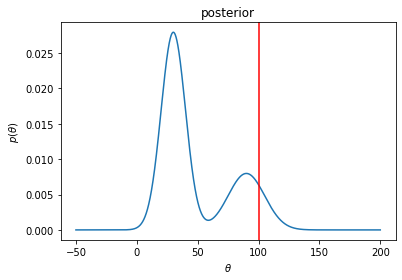

In [4]:
plt.plot(thetas, p(thetas).detach())
plt.axvline(th_crit, color='r')
plt.title('posterior')
plt.xlabel(r'$\theta$'); plt.ylabel(r'$p(\theta)$')
plt.show()

To visualize the difference between forward and reverse KL, we are going to approximate the GMM with a single Gaussian.

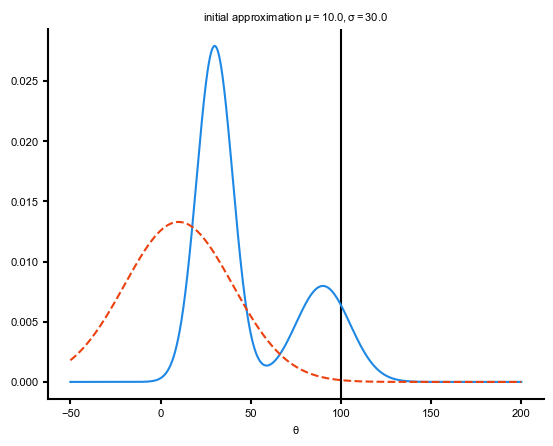

tensor(47.3600)

In [5]:
# approximation
q_mu = 10.     #torch.randint(0, 120, (1,))
q_sigma = 30.  #torch.randint(0, 60, (1,))
q = Normal(q_mu, q_sigma)

with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    plt.axvline(th_crit, color='k')
    plt.plot(thetas, p(thetas), color='#1E88E5')
    plt.plot(thetas, q.log_prob(thetas).exp(), color='#EC400E', linestyle='--')
    plt.title(f'initial approximation $\mu={q_mu}, \sigma={q_sigma}$')
    plt.xlabel(r'$\theta$'); 
    plt.show()
kl_div.kl(p(thetas), q.log_prob(thetas))


### Minimize forward KL

In [6]:
epochs = 50000
mu, sigma, q_logevals_all, loss_vals = kl_div.minimize_kl(q_mu, q_sigma, thetas, p, epochs, 'forward')


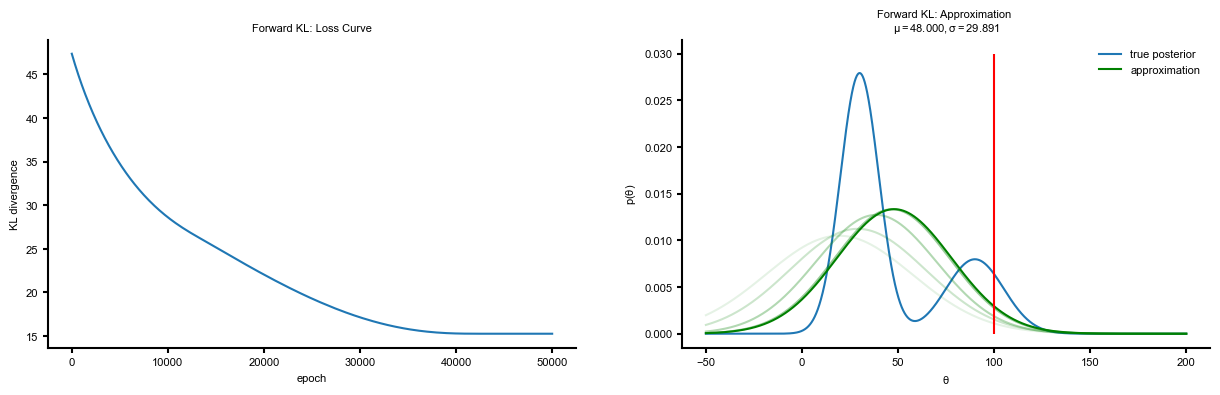

final loss: 15.273832321166992


In [7]:
with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(np.arange(epochs), loss_vals)
    plt.title('Forward KL: Loss Curve')
    plt.xlabel('epoch'); plt.ylabel('KL divergence')

    plt.subplot(1,2,2)
    plt.plot(thetas, p(thetas), label='true posterior')
    for i in range(5):
        plt.plot(thetas, np.exp(q_logevals_all[int(i*0.2*epochs)]), c='green', alpha=0.1*i)
    plt.plot(thetas, np.exp(q_logevals_all[-1]), c='green', label='approximation')
    plt.vlines(th_crit, ymin=0, ymax=0.03, colors='red')

    plt.title(f'Forward KL: Approximation \n$\mu={mu:.3f}, \sigma={sigma:.3f}$')
    plt.xlabel(r'$\theta$'); plt.ylabel(r'$p(\theta)$')
    plt.legend()
    plt.show()
    print(f'final loss: {loss_vals[-1]}')

### Minimize reverse KL

In [8]:
epochs = 50000
mu_rev, sigma_rev, q_logevals_all_rev, loss_vals_rev = kl_div.minimize_kl(q_mu, q_sigma, thetas, p, epochs, 'reverse')

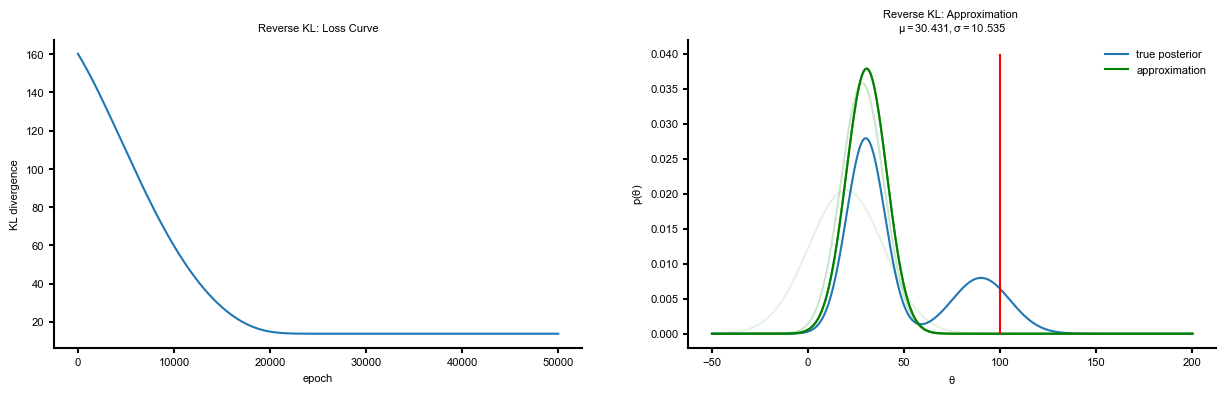

final loss: 13.726123809814453


In [9]:
with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(np.arange(epochs), loss_vals_rev)
    plt.title('Reverse KL: Loss Curve')
    plt.xlabel('epoch'); plt.ylabel('KL divergence')

    plt.subplot(1,2,2)
    plt.plot(thetas, p(thetas), label='true posterior')
    for i in range(5):
        plt.plot(thetas, np.exp(q_logevals_all_rev[int(i*0.2*epochs)]), c='green', alpha=0.1*i)
    plt.plot(thetas, np.exp(q_logevals_all_rev[-1]), c='green', label='approximation')
    plt.vlines(th_crit, ymin=0, ymax=0.04, colors='red')
    #plt.hist(samples.numpy(), bins=100, density=True)
    plt.title(f'Reverse KL: Approximation \n$\mu={mu_rev:.3f}, \sigma={sigma_rev:.3f}$')
    plt.xlabel(r'$\theta$'); plt.ylabel(r'$p(\theta)$')
    plt.legend()
    plt.show()
    print(f'final loss: {loss_vals_rev[-1]}')